In [1]:
import rasterio
from rasterio.plot import show
import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform
from osgeo import gdal

import sys, os
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
from pandas.io import sql
from pandas.io.json import json_normalize
import numpy as np
from datetime import date, timedelta
from datetime import datetime
import time
import re
import pylab as py
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.optimize import minimize
from sklearn.model_selection import KFold
from scipy.optimize import curve_fit
import george
from george import kernels

In [2]:
from GP_temp_elev import *
from getMap_matrix import *

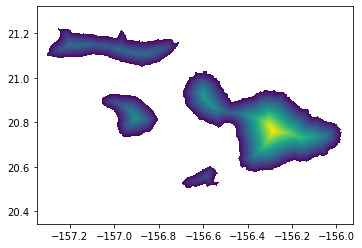

In [3]:
fname = r'./geoTiffs_250m/coastDist/mn_coastDistM_250m.tif'

img = rasterio.open(fname)
show(img)

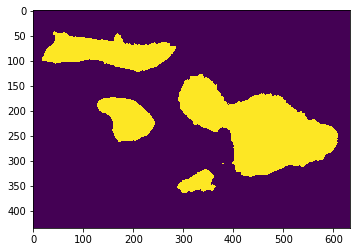

(-3.4e+38,)

In [4]:
src = rasterio.open(fname)
msk = src.read_masks(1)
plt.imshow(msk, interpolation='none')
plt.show()
src.nodatavals

In [5]:
X_grid = getmap(fname)

In [6]:
def esnModel(theta, X_train, X_test, y_train, y_test, Hinv=2150, biLinear=False):
    
        zp = theta[0]
        slope = theta[1]
        l1 = np.exp(theta[2])
        l2 = np.exp(theta[3])
        sigma = np.exp(theta[4])
        err = np.exp(theta[5])
        
        if biLinear:
            s2 = theta[6]
        

        y_model = slope*X_train[:,2]+zp
        
        if biLinear:
            ind, = np.where(X_train[:,2]>Hinv)
            y_model[ind] += s2*(X_train[:,2][ind]-Hinv)

        kernel = sigma * kernels.ExpSquaredKernel([l1 , l2], ndim=2)
        gp = george.GP(kernel)
        gp.compute(X_train[:,:2], err)

        y_res_test, cov = gp.predict(y_train-y_model, X_test[:,:2], return_var=True)

        y_model_test = slope*X_test[:,2]+zp
        
        if biLinear:
            ind, = np.where(X_test[:,2]>Hinv)
            y_model_test[ind] += s2*(X_test[:,2][ind]-Hinv)    
        
        
        return y_res_test+y_model_test, cov

In [7]:
def getData(inFile='Tmax_QC.csv', island='BI', date_str='05/01/2018'):
    
    df = pd.read_csv(inFile, encoding = "ISO-8859-1", engine='python')

    meta_columns = ['SKN', 'Station.Name', 'Observer', 'Network', 'Island', 'ELEV.m.',
       'LAT', 'LON', 'NCEI.id', 'NWS.id', 'NESDIS.id', 'SCAN.id',
       'SMART_NODE_RF.id']
    Temp_columns = df.columns[13:]


    df2 = df[meta_columns]
    df2 = df2.set_index("SKN")
    df2 = df2[(df2.Island==island)]

    df1 = df[["SKN"]+list(Temp_columns)].T
    new_header = df1.iloc[0]
    df1 = df1[1:] 
    df1.columns = new_header 
    df1.index = pd.to_datetime([x.split('X')[1] for x in df1.index.values])
    df1.index.name = 'Date'
    df1 = df1[list(df2.index.values)]

    df3 = df2[["LON", "LAT", "ELEV.m."]].T
    df3 = df3[list(df2.index.values)]

    df_station =  df3.T
    df_station = df_station.join(df1.T, how='left')
    
    
    df_station =  df3.T
    df_station = df_station.join(df1.T, how='left')

    Date = pd.to_datetime(date_str)

    data = df_station[["LON", "LAT", "ELEV.m.", Date]].dropna()
    X = data[["LON", "LAT", "ELEV.m."]].values
    SKN = data.index.values
    y = data[Date].values
    
    return X, y

In [8]:
X_data, y_data = getData()

In [9]:
Hmax = np.max(X_data[:,2])
if Hmax>2150:
    biLinear=True
    n_param=7
    linn_param = 3
else:
    biLinear=False
    n_param=6
    linn_param = 2

indx, a, b, c, MAE_lin, RMSE_lin, R2_lin, AIC_lin, BIC_lin  = ourliers(X_data, y_data)
output = solver(X_data, y_data, indx, biLinear=biLinear)

output.sort(key= lambda x: x[0], reverse=True)

theta = output[0][1]
R2 = output[0][0]

In [16]:
X_grid.shape

(275355, 3)

In [10]:
y_grid, cov = esnModel(theta, X_data, X_grid, y_data, _, biLinear=biLinear)

In [11]:
R2, R2_lin

(0.849485542377723, 0.808625590432621)

In [14]:
import os
import gdal

ds = gdal.Open(fname)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
cols, rows = arr.shape


arr_out = y_grid.reshape(cols, rows)
indx = msk<200
arr_out[indx] = -1000

driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create("BI_Tmax_05012018.tiff", rows, cols, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(arr_out)
outdata.GetRasterBand(1).SetNoDataValue(-1000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band = None
ds = None

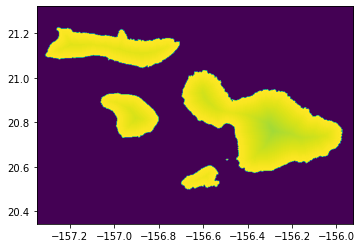

In [15]:
img = rasterio.open('BI_Tmax_05012018.tiff')
show(img)